Data ready. Training on 94 samples.

XGBOOST MODEL PERFORMANCE
R2 Score: 0.9553
Mean Squared Error: 482.29

SAMPLE PREDICTIONS (ACTUAL vs PREDICTED)
     Actual Hydro  Actual Digester  Pred Hydro  Pred Digester  Diff Hydro
58          400.0            400.0  400.034760     399.999725   -0.034760
33          350.0            350.0  350.333557     349.999908   -0.333557
82          400.0            400.0  399.999908     399.999695    0.000092
140         400.0            400.0  392.869476     399.999725    7.130524
2           100.0            150.0  173.489288     150.033829  -73.489288
37          350.0            350.0  349.997589     349.999908    0.002411
57          400.0            400.0  399.939667     399.999695    0.060333
132         400.0            400.0  400.001251     399.999725   -0.001251
16          250.0            250.0  256.879944     259.060913   -6.879944
64          400.0            400.0  392.892120     399.999725    7.107880

Generating SHAP Explanations...
>> E

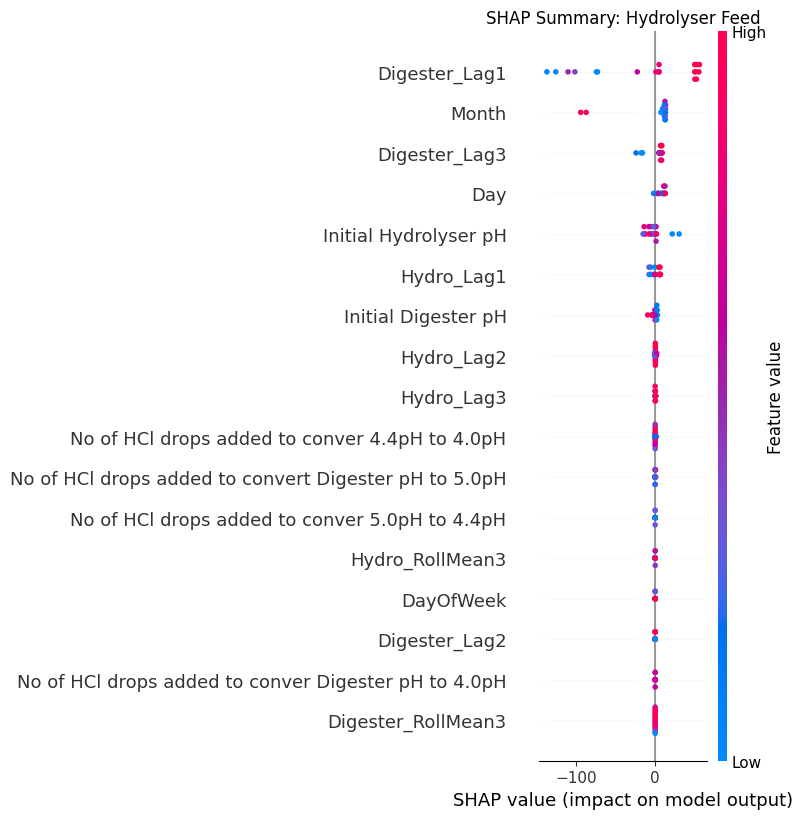

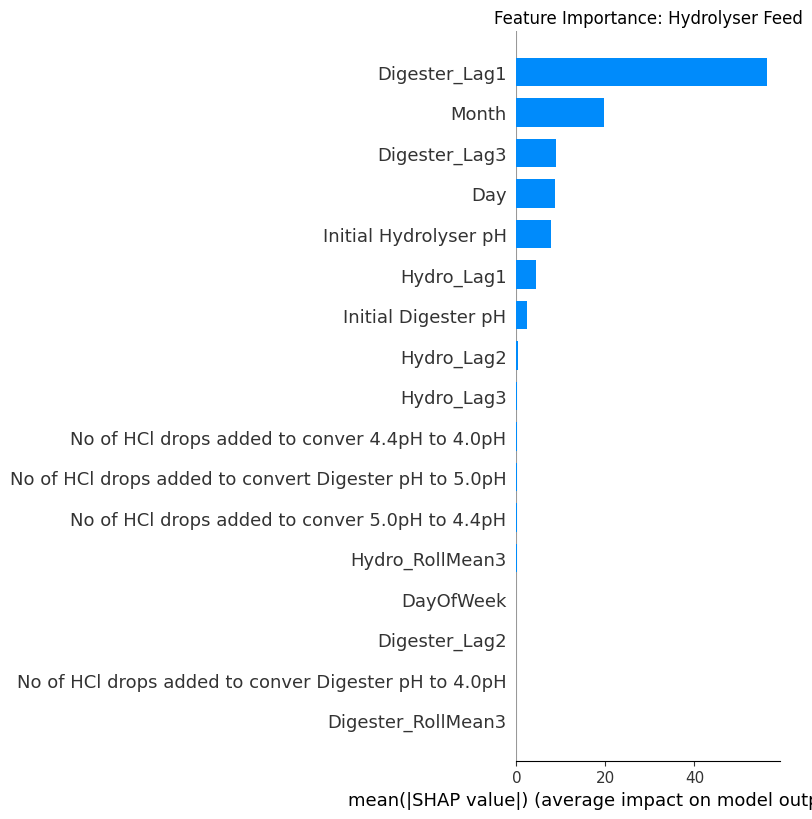

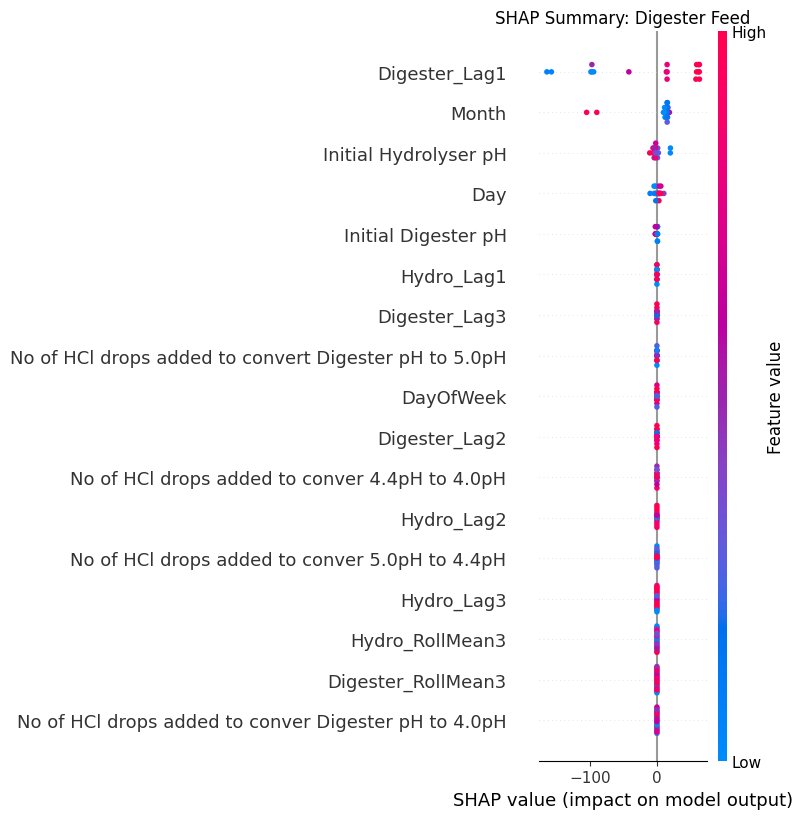

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Try to import SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Warning: 'shap' library not found. Install it using 'pip install shap'.")

# ==========================================
# 1. Load and Preprocess Data
# ==========================================
file_path = 'combined_file.csv'
df = pd.read_csv(file_path)

# Robust Date Parsing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')

# Feature Engineering: Time Series Lags
# Use temporary forward-fill to calculate history
df_filled = df.copy()
df_filled['Recommended Feed to Hydrolyser'] = df_filled['Recommended Feed to Hydrolyser'].ffill()
df_filled['Recommonded Feed to Digester'] = df_filled['Recommonded Feed to Digester'].ffill()

# Create Lags (1, 2, 3 days back)
for lag in [1, 2, 3]:
    df[f'Hydro_Lag{lag}'] = df_filled['Recommended Feed to Hydrolyser'].shift(lag)
    df[f'Digester_Lag{lag}'] = df_filled['Recommonded Feed to Digester'].shift(lag)

# Create Rolling Means (3-day average)
df['Hydro_RollMean3'] = df_filled['Recommended Feed to Hydrolyser'].shift(1).rolling(window=3).mean()
df['Digester_RollMean3'] = df_filled['Recommonded Feed to Digester'].shift(1).rolling(window=3).mean()

# Extract Date Features
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Define Features (X) and Targets (y)
X_cols = [
    'Initial Hydrolyser pH', 'Initial Digester pH',
    'No of HCl drops added to convert Digester pH to 5.0pH',
    'No of HCl drops added to conver 5.0pH to 4.4pH',
    'No of HCl drops added to conver 4.4pH to 4.0pH',
    'No of HCl drops added to conver Digester pH to 4.0pH',
    'Hydro_Lag1', 'Hydro_Lag2', 'Hydro_Lag3',
    'Digester_Lag1', 'Digester_Lag2', 'Digester_Lag3',
    'Hydro_RollMean3', 'Digester_RollMean3',
    'Month', 'Day', 'DayOfWeek'
]

y_cols = ['Recommended Feed to Hydrolyser', 'Recommonded Feed to Digester']

# Data Cleaning
df_clean = df.dropna(subset=X_cols + y_cols).copy()
X = df_clean[X_cols]
y = df_clean[y_cols]

print(f"Data ready. Training on {len(X)} samples.")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. Train XGBoost Model
# ==========================================
# We use MultiOutputRegressor to handle 2 targets (Hydrolyser & Digester)
# XGBRegressor handles NaNs and scaling automatically, so we don't strictly need StandardScaler
xgb_estimator = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

model = MultiOutputRegressor(xgb_estimator)
model.fit(X_train, y_train)

# ==========================================
# 3. Evaluate and Show Results
# ==========================================
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("\n" + "="*40)
print(f"XGBOOST MODEL PERFORMANCE")
print("="*40)
print(f"R2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")

# Create Results Table
results_df = pd.DataFrame(
    y_test.values,
    columns=['Actual Hydro', 'Actual Digester'],
    index=y_test.index
)
results_df['Pred Hydro'] = y_pred[:, 0]
results_df['Pred Digester'] = y_pred[:, 1]
results_df['Diff Hydro'] = results_df['Actual Hydro'] - results_df['Pred Hydro']

print("\n" + "="*40)
print("SAMPLE PREDICTIONS (ACTUAL vs PREDICTED)")
print("="*40)
print(results_df.head(10))
print("="*40)

# ==========================================
# 4. Explainable AI (SHAP)
# ==========================================
if SHAP_AVAILABLE:
    print("\nGenerating SHAP Explanations...")

    # MultiOutputRegressor wraps two separate XGBoost models.
    # We must access them individually to explain them.

    # --- Explain Target 1: Recommended Feed to Hydrolyser ---
    print(">> Explaining 'Recommended Feed to Hydrolyser'...")

    # Access the first internal model (index 0 corresponds to first column in y)
    hydro_model = model.estimators_[0]

    # TreeExplainer is fast and native for XGBoost
    explainer = shap.TreeExplainer(hydro_model)
    shap_values = explainer.shap_values(X_test)

    # 1. Summary Plot (Beeswarm)
    plt.figure(figsize=(10, 6))
    plt.title("SHAP Summary: Hydrolyser Feed")
    shap.summary_plot(shap_values, X_test, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_xgb_hydro.png')
    print("   Saved 'shap_summary_xgb_hydro.png'")

    # 2. Bar Plot (Importance)
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance: Hydrolyser Feed")
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('shap_barplot_xgb_hydro.png')
    print("   Saved 'shap_barplot_xgb_hydro.png'")

    # --- Explain Target 2: Recommended Feed to Digester ---
    print(">> Explaining 'Recommended Feed to Digester'...")
    digester_model = model.estimators_[1]

    explainer_dig = shap.TreeExplainer(digester_model)
    shap_values_dig = explainer_dig.shap_values(X_test)

    plt.figure(figsize=(10, 6))
    plt.title("SHAP Summary: Digester Feed")
    shap.summary_plot(shap_values_dig, X_test, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_xgb_digester.png')
    print("   Saved 'shap_summary_xgb_digester.png'")

    print("SHAP analysis complete.")
else:
    print("\nSkipping SHAP analysis (library not installed).")